In [1]:
import json

In [2]:
data_paths = ["annotated_train.json", "fixed_newdata1.json", "fixed_newdata2.json", "newdata3_temp1.json"]

In [71]:
raw_data = []
for path in data_paths:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    raw_data.extend(data)

In [35]:
len(raw_data)

372

In [14]:
import sys
sys.path.append("../")

In [40]:
from chat_bot.neural_chat.craigslist.price_parser import price_to_int, parse_prices

In [72]:
# price to int
for d in raw_data:
    d["price"] = str(d["price"])
    d["price"] = d["price"].replace("원", "")
    d["price"] = price_to_int(d["price"])

In [73]:
# strip
for d in raw_data:
    d["title"] = d["title"].strip()
    d["description"] = d["description"].strip()
    for ev in d["events"]:
        ev["message"] = ev["message"].strip()

In [74]:
# add result
for d in raw_data:
    if d["events"][-1]["role"] == "판매자": continue
    if d["result"] == "ACCEPT":
        d["events"].append({"role": "판매자", "message": "##<수락>##"})
    elif d["result"] == "DENY":
        d["events"].append({"role": "판매자", "message": "##<거절>##"})
    else:
        raise NotImplementedError

In [75]:
# check turns
roles = ["구매자", "판매자"]
for d in raw_data:
    for i, ev in enumerate(d["events"]):
        assert ev["role"] == roles[i % 2], f"{i}"

In [76]:
# check final price
for i, d in enumerate(raw_data):
    if int(d["events"][-2]["message"][3:-3]) < d["price"] // 2:
        print(i)

In [77]:
def price_to_text(price):
    text = ""
    q, r = divmod(price, 10000)
    if q: text += f"{q}만 "
    q, r = divmod(r, 1000)
    if q: text += f"{q}천 "
    q, r = divmod(r, 100)
    if q: text += f"{q}백"
    
    return text.strip()

In [92]:
from matplotlib import pyplot as plt
from transformers import AutoTokenizer
from chat_bot.neural_chat.conversation import get_default_conv_template

In [89]:
tokenizer = AutoTokenizer.from_pretrained("nlpai-lab/kullm-polyglot-12.8b-v2")

In [93]:
results = {"accepted": 0, "denied": 0}
token_lens = []

for d in raw_data:
    if d["result"] == "ACCEPT":
        results["accepted"] += 1
    else:
        results["denied"] += 1
    
    conv = get_default_conv_template()
    conv.load_dict(d)
    tokens = tokenizer.encode(conv.get_prompt())
    token_lens.append(len(tokens))
    

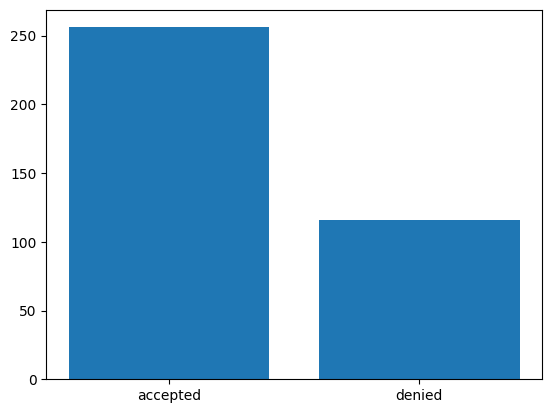

In [97]:
plt.bar(results.keys(), results.values())
plt.show()

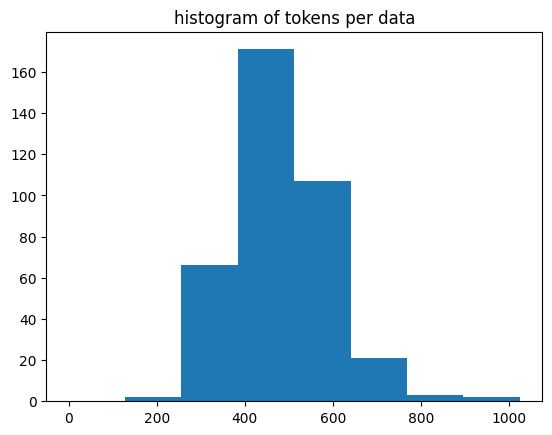

In [105]:
plt.hist(token_lens, bins=8, range=(0, 1024))
plt.title("histogram of tokens per data")
plt.show()

In [78]:
import random

In [79]:
# diverse price formats
for d in raw_data:
    if random.random() < 0.5: continue # re-format random 50% of datas
    for ev in d["events"][:-2]:
        price_list, match_list = parse_prices(ev["message"], d["price"], 0.7, 1)

        for price, match in zip(reversed(price_list), reversed(match_list)):
            text = price_to_text(price)
            ev["message"] = ev["message"][:match.start()] + text + ev["message"][match.end():]

In [86]:
# save
with open("annotated_train_372.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(raw_data, indent=2, ensure_ascii=False))